# Exploratory analysis of combined dataset

In [480]:
from pathlib import Path
import warnings

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
# from ydata_profiling import ProfileReport

In [481]:
# Current versions of XGBoost and Seaborn have a FutureWarning bug; suppress with this
warnings.simplefilter(action='ignore', category=FutureWarning)

In [384]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 50

In [385]:
# Paths to data directories
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Read in data (and wrangle a bit)

In [386]:
df = pd.read_pickle(data_push_path / 'df_main_smard_era5_final_reordered.pkl')

# drop CET datetime column; no longer needed
# df.drop(columns=['datetime_cet'], inplace=True)
# move label/target to the end of the dataframe
# rearranged_columns = [col for col in df.columns if col != 'actual_generated_smard_mwh'] + ['actual_generated_smard_mwh']
# df = df[rearranged_columns]

# split off SMARD forecasted and actuals into separate dataframe and drop SMARD forecasted
df_smard_preds_vs_actuals = df.loc[:, ['forecasted_generation_smard_mwh', 'actual_generated_smard_mwh']].copy()
df.drop(columns=['forecasted_generation_smard_mwh'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48168 entries, 2018-01-01 00:00:00+00:00 to 2023-06-30 23:00:00+00:00
Data columns (total 34 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   hour                                            48168 non-null  int32  
 1   day_of_week                                     48168 non-null  int32  
 2   day_of_month                                    48168 non-null  int32  
 3   day_of_year                                     48168 non-null  int32  
 4   week_of_year                                    48168 non-null  UInt32 
 5   month_number                                    48168 non-null  int32  
 6   year                                            48168 non-null  int32  
 7   meteorological_season                           48168 non-null  object 
 8   public_holiday                                  48168 non-null  int64

In [39]:
# Add two new datetime properties to dataframe
# df['day_of_year'] = df.index.day_of_year
# df['week_of_year'] = df.index.isocalendar().week

In [35]:
# Forward fill the 24 missing hourly values of forecasted generation that occured on 2022-12-21
# df['forecasted_generation_smard_mwh'] = df['forecasted_generation_smard_mwh'].ffill()

# # Save to pickle
# df.to_pickle(data_push_path / 'df_main_smard_era5_final_reordered.pkl')

In [40]:
# The column order I want: save to pickle to persist this order
# Also, I purposely chose not to keep datetime_cet as no longer needed going forward

# desired_column_order = [
#     # Datetimeindex properties
#     'hour',
#     'day_of_week',
#     'day_of_month',
#     'day_of_year',
#     'week_of_year',
#     'month_number',
#     'year',
#     'meteorological_season',
#     # From feiertage-api.de
#     'public_holiday',
#     # Derived from wind turbines dataset
#     'turbines_in_operation',
#     'total_nominal_capacity_operational_turbines_mw',
#     # From SMARD
#     'total_nominal_capacity_smard_mw',
#     'day_ahead_price_eur_mwh',
#     'total_net_load_smard_mwh',
#     'residual_load_smard_mwh',
#     # From ERA5
#     'temp_2m_celsius',
#     'mean_sea_level_pressure_mb',
#     'wind_gusts_10m',
#     'mean_wind_speed_10m',
#     'mean_wind_speed_100m',
#     'wind_direction_angle_10m',
#     'wind_direction_angle_100m',
#     'wind_direction_intercardinal_10m',
#     'wind_direction_intercardinal_100m',
#     # Derived from ERA5 using grid weights derived from wind turbines dataset
#     'weighted_temp_2m_celsius',
#     'weighted_mean_sea_level_pressure_mb',
#     'weighted_wind_gusts_10m',
#     'weighted_mean_wind_speed_10m',
#     'weighted_mean_wind_speed_100m',
#     'weighted_mean_wind_direction_angle_10m',
#     'weighted_mean_wind_direction_angle_100m',
#     'weighted_wind_direction_intercardinal_10m',
#     'weighted_wind_direction_intercardinal_100m',
#     # SMARD day-ahead power forecast vs actuals (i.e. my label)
#     'forecasted_generation_smard_mwh',
#     'actual_generated_smard_mwh',
# ]

# df = df[desired_column_order]

# # Save to pickle
# df.to_pickle(data_push_path / 'df_main_smard_era5_final_reordered.pkl')

In [387]:
# Separate these ERA5 and ERA5-derived param groups for quicker selections later
weighted_wx_features = [
    'weighted_temp_2m_celsius',
    'weighted_mean_sea_level_pressure_mb',
    'weighted_wind_gusts_10m',
    'weighted_mean_wind_speed_10m',
    'weighted_mean_wind_speed_100m',
    'weighted_mean_wind_direction_angle_10m',
    'weighted_mean_wind_direction_angle_100m',
    'weighted_wind_direction_intercardinal_10m',
    'weighted_wind_direction_intercardinal_100m',
]

unweighted_wx_features = [
    'temp_2m_celsius',
    'mean_sea_level_pressure_mb',
    'wind_gusts_10m',
    'mean_wind_speed_10m',
    'mean_wind_speed_100m',
    'wind_direction_angle_10m',
    'wind_direction_angle_100m',
    'wind_direction_intercardinal_10m',
    'wind_direction_intercardinal_100m',
]

# Create separate dataframes as well
df_weighted = df.loc[:, ~df.columns.isin(unweighted_wx_features)].copy()
df_unweighted = df.loc[:, ~df.columns.isin(weighted_wx_features)].copy()

In [388]:
df.isna().sum()

hour                                                 0
day_of_week                                          0
day_of_month                                         0
day_of_year                                          0
week_of_year                                         0
month_number                                         0
year                                                 0
meteorological_season                                0
public_holiday                                       0
turbines_in_operation                                0
total_nominal_capacity_operational_turbines_mw       0
total_nominal_capacity_smard_mw                      0
day_ahead_price_eur_mwh                           6550
total_net_load_smard_mwh                             0
residual_load_smard_mwh                              0
temp_2m_celsius                                      0
mean_sea_level_pressure_mb                           0
wind_gusts_10m                                       0
mean_wind_

In [389]:
df.describe()

,hour,day_of_week,day_of_month,day_of_year,week_of_year,month_number,year,public_holiday,turbines_in_operation,total_nominal_capacity_operational_turbines_mw,total_nominal_capacity_smard_mw,day_ahead_price_eur_mwh,total_net_load_smard_mwh,residual_load_smard_mwh,temp_2m_celsius,mean_sea_level_pressure_mb,wind_gusts_10m,mean_wind_speed_10m,mean_wind_speed_100m,wind_direction_angle_10m,wind_direction_angle_100m,weighted_temp_2m_celsius,weighted_mean_sea_level_pressure_mb,weighted_wind_gusts_10m,weighted_mean_wind_speed_10m,weighted_mean_wind_speed_100m,weighted_mean_wind_direction_angle_10m,weighted_mean_wind_direction_angle_100m,actual_generated_smard_mwh
count,48168.000000,48168.000000,48168.000000,48168.00000,48168.0,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,41618.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000
mean,11.500000,2.997509,15.716492,174.79422,25.414051,6.251619,2020.270553,0.002429,28625.879422,54216.183891,53849.704638,97.951645,56219.703579,36924.776340,10.216761,1016.364811,6.945310,3.403946,5.747104,191.878098,194.632889,10.357187,1015.912618,7.247443,3.642511,6.125059,195.617986,198.109288,11193.426461
std,6.922258,1.999396,8.793736,105.13965,15.032076,3.439449,1.599109,0.049225,462.136710,2355.850195,1700.822139,107.700848,9832.762332,12559.928192,7.485719,9.026248,2.917239,1.373546,2.210253,64.455742,65.061592,7.343503,9.431296,3.079814,1.496988,2.373912,67.100808,67.589109,8992.759097
min,0.000000,0.000000,1.000000,1.00000,1.0,1.000000,2018.000000,0.000000,27464.000000,49732.097897,51633.000000,-129.960000,30909.000000,-5370.500000,-12.340430,972.342813,1.910964,0.819818,1.150553,22.478209,21.372946,-12.353219,971.750173,1.816411,0.860357,1.186652,18.788045,19.789689,100.250000
25%,5.750000,1.000000,8.000000,84.00000,12.0,3.000000,2019.000000,0.000000,28304.000000,52353.193417,52792.000000,35.050000,48175.687500,28525.562500,4.303812,1011.134180,4.782694,2.391495,4.161518,146.448418,148.723846,4.642113,1010.345478,4.962623,2.527088,4.397004,147.137573,148.870189,4245.875000
50%,11.500000,3.000000,16.000000,168.00000,24.0,6.000000,2020.000000,0.000000,28664.000000,53790.932467,53184.000000,53.920000,56035.250000,37295.125000,9.597971,1016.906797,6.369528,3.090817,5.346018,200.376053,204.613251,9.776790,1016.555933,6.645048,3.320524,5.722192,207.578807,211.532572,8473.000000
75%,17.250000,5.000000,23.000000,265.00000,38.0,9.000000,2022.000000,0.000000,28982.000000,56033.684347,55289.000000,119.802500,64212.000000,45628.437500,15.746774,1022.105957,8.502666,4.094744,6.930403,242.063076,245.364609,15.714599,1022.037480,8.909549,4.424359,7.448320,247.089817,249.770198,15918.500000
max,23.000000,6.000000,31.000000,366.00000,53.0,12.000000,2023.000000,1.000000,29418.000000,59315.041337,57590.000000,871.000000,81077.500000,74313.250000,33.672296,1041.468125,23.699093,11.017428,17.585875,335.886993,338.821259,33.866775,1041.719498,25.159453,12.178314,19.184025,339.868895,341.861569,45285.250000


-----

### Just had an idea: Add German public holidays data to dataset as an additional feature/predictor!

#### Fetch German public holiday dates from free API service (thanks, guys! 👍🏻)
- Link: https://feiertage-api.de
- 117 public holidays during my chosen time period

In [7]:
# years = [2018, 2019, 2020, 2021, 2022, 2023]
# list_of_datadicts = []

# for year in years:
#     url_endpoint = f'https://feiertage-api.de/api/?jahr={year}&nur_daten'
#     response = requests.get(url_endpoint)

#     if response.status_code == 200:  
#             # Decode JSON response object to Python dict
#             list_of_datadicts.append(response.json())
#     else:
#         print(f'Request failed with status code: {response.status_code}')
        
# len(list_of_datadicts)

6

In [29]:
# df_public_holidays = pd.DataFrame(list_of_datadicts)

# # Map all dates to datetime timestamps localise to UTC (since only day alignment is needed, not hourly)
# df_public_holidays = df_public_holidays.map(lambda date: pd.to_datetime(date, yearfirst=True, utc=True))

# # Flatten the dataframe to 1D array of Timestamps!
# public_holiday_timestamps = df_public_holidays.to_numpy().flatten()

# # Creat new column by putting bool array as condition inside np.where and replacing bool with 0s & 1s
# df['public_holiday'] = np.where(df.index.isin(public_holiday_timestamps), 1, 0)

In [37]:
# df['public_holiday'].sum()

117

#### Save to pickle

In [38]:
# df.to_pickle(data_push_path / 'df_main_smard_era5_final.pkl')

-----

-----

## Check for linear correlations between features and label

In [403]:
def plot_correlation_heatmap(df):
    # Get the correlation matrix as a dataframe
    corr = df.corr(numeric_only=True)

    # Create mask to remove redundant half
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Abbreviate column names; select only numeric columns in df!
    abbreviated_column_names = [col[:40] + '...' if len(col) > 40 else col for col in df.select_dtypes('number').columns]
    
    # A couple of divergent colour palettes to see what works best
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # cmap = sns.color_palette("coolwarm", as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={'shrink': .2}, annot=True, fmt='.2f', annot_kws={'size': 6},
                xticklabels=abbreviated_column_names, yticklabels=abbreviated_column_names)
    
    # Rotate x labels for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=7)
    
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
    # Set the target name in bold
    y_labels = ax.get_yticklabels()
    y_labels[-1].set_weight('bold')
    
    # Title
    ax.set_title('Correlation heatmap')
    
    # plt.tight_layout()
    plt.show()

#### Using `df_unweighted`

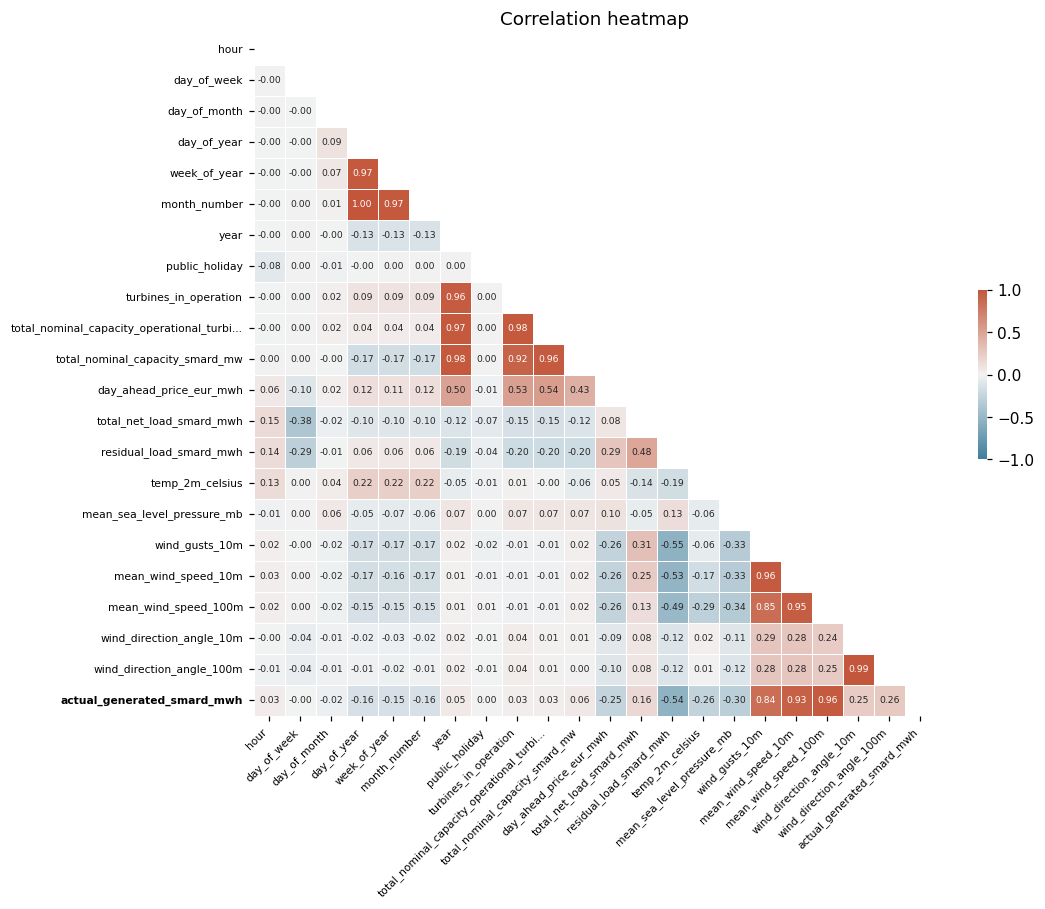

In [404]:
plot_correlation_heatmap(df_unweighted)

#### Using `df_weighted`: Stronger linear correlations between label and weighted wind features!
- Especially 100m wind, 10m gusts, and msl

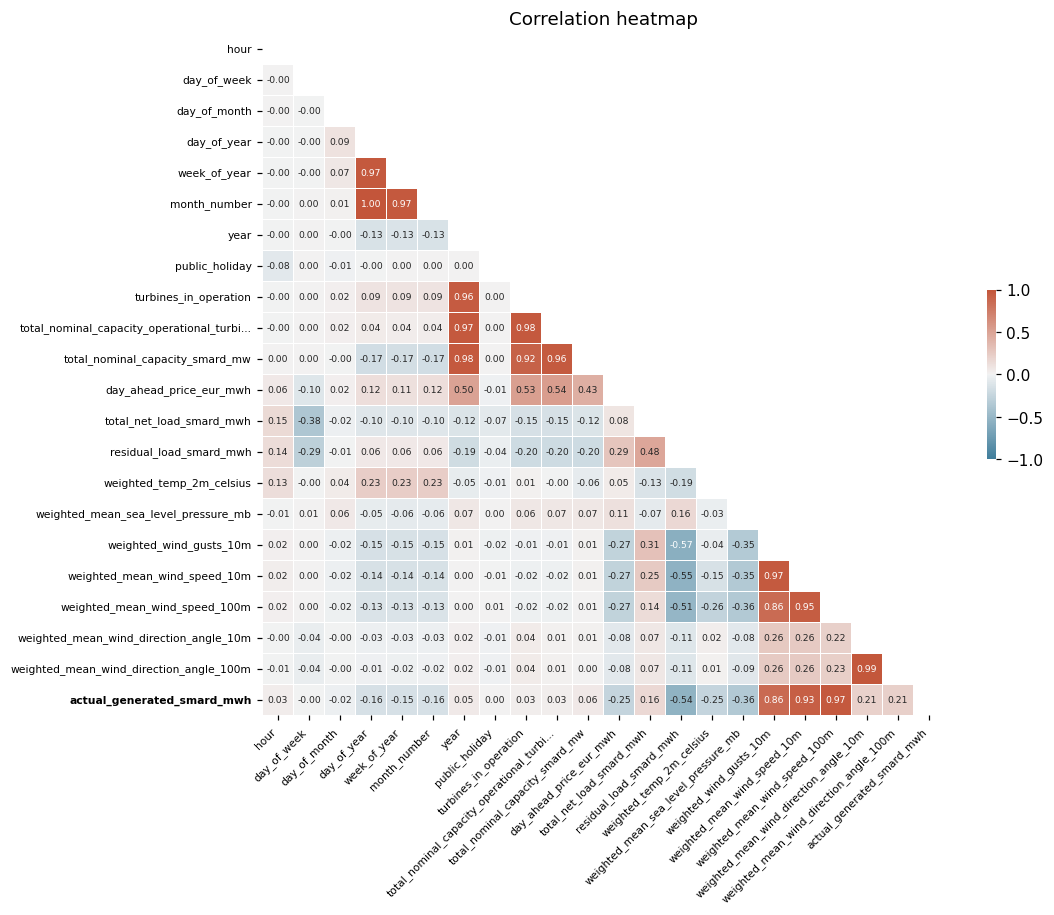

In [405]:
plot_correlation_heatmap(df_weighted)

----

#### The target variable and mean wind speed at 100m are highly linearly correlated with yearly seasonality

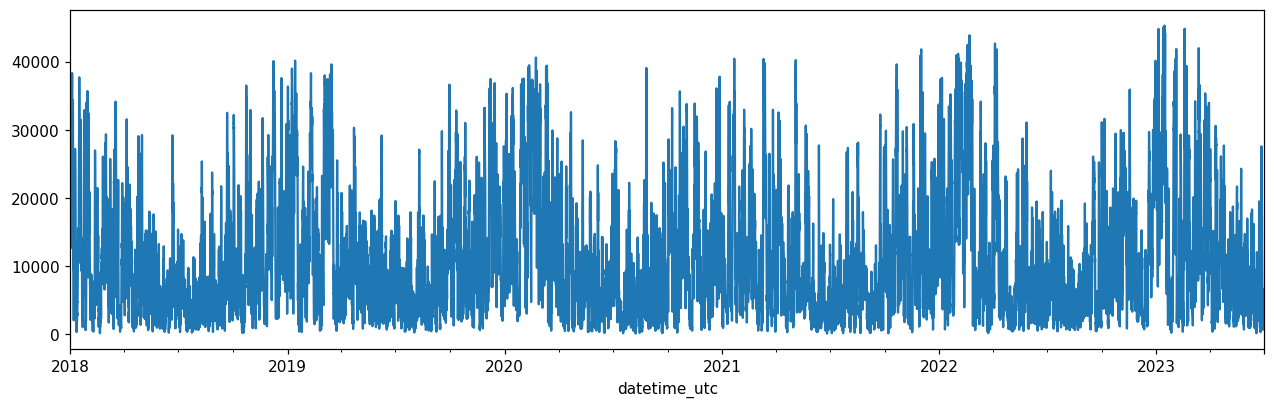

In [554]:
df['actual_generated_smard_mwh'].plot(figsize=(14,4));

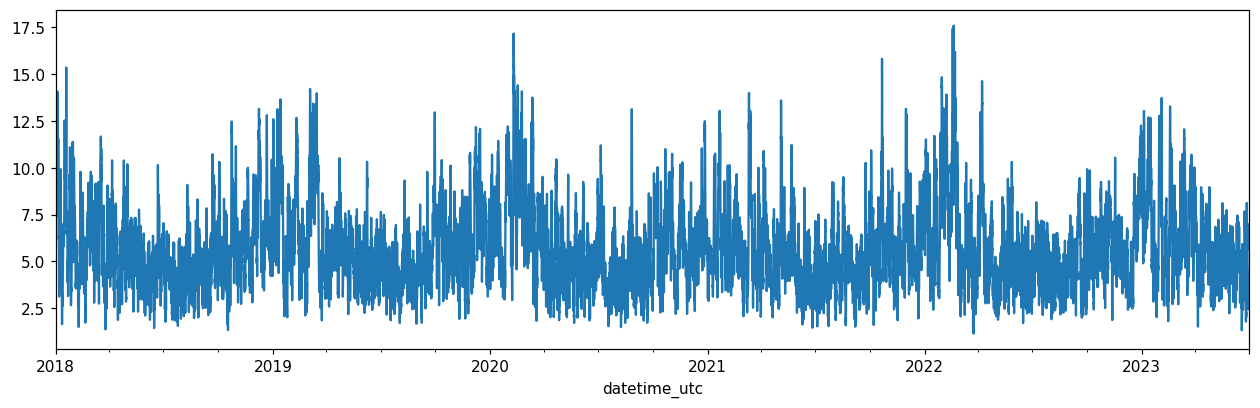

In [552]:
df['mean_wind_speed_100m'].plot(figsize=(14,4));

#### Total nominal capacity: SMARD vs my engineered feature
- SMARD data has a temporal resolution of yearly while mine is quasi-daily (using operational dates in wind turbines dataset)

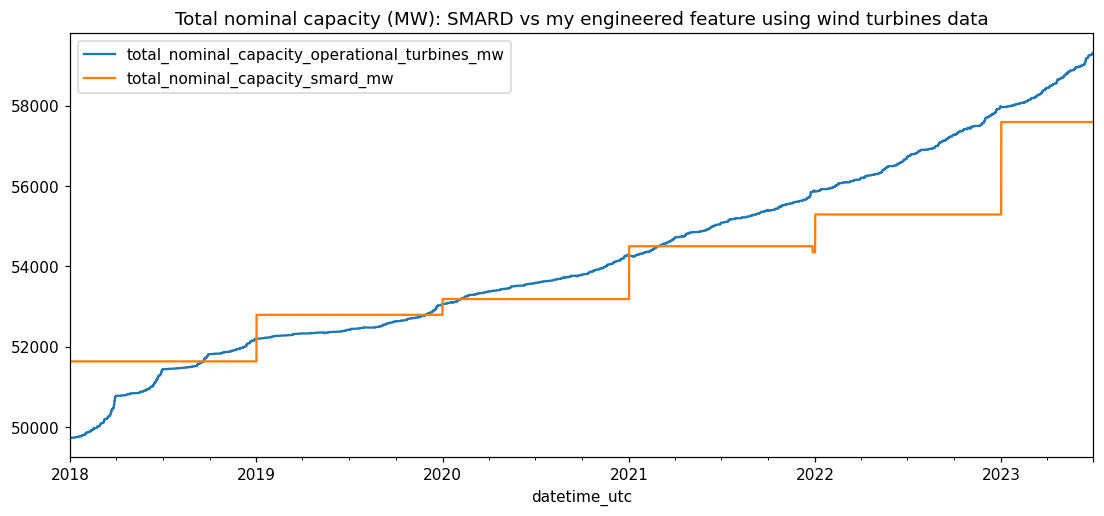

In [563]:
df.plot(
    kind='line', 
    y=['total_nominal_capacity_operational_turbines_mw', 'total_nominal_capacity_smard_mw'],
    figsize=(12,5),
    title='Total nominal capacity (MW): SMARD vs my engineered feature using wind turbines data'
);

#### A 'zoomed in' look at the target variable over the course of several weeks

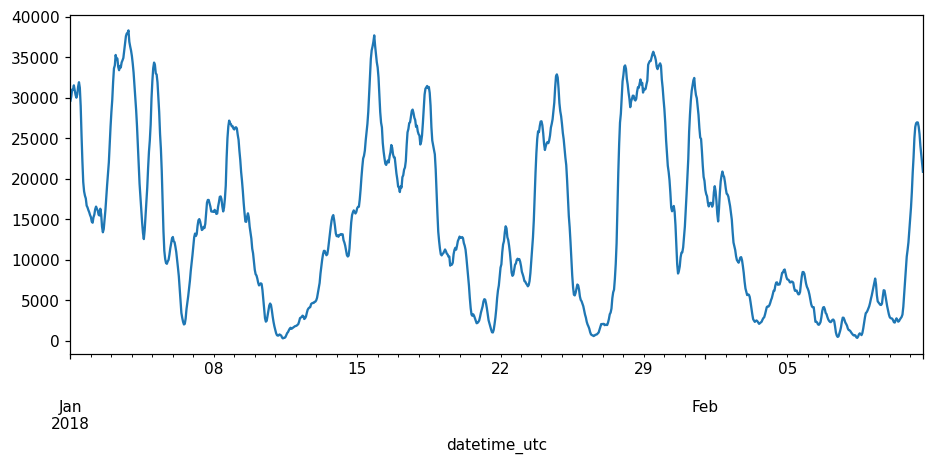

In [394]:
df['actual_generated_smard_mwh'].iloc[0:1_000].plot(figsize=(10,4));

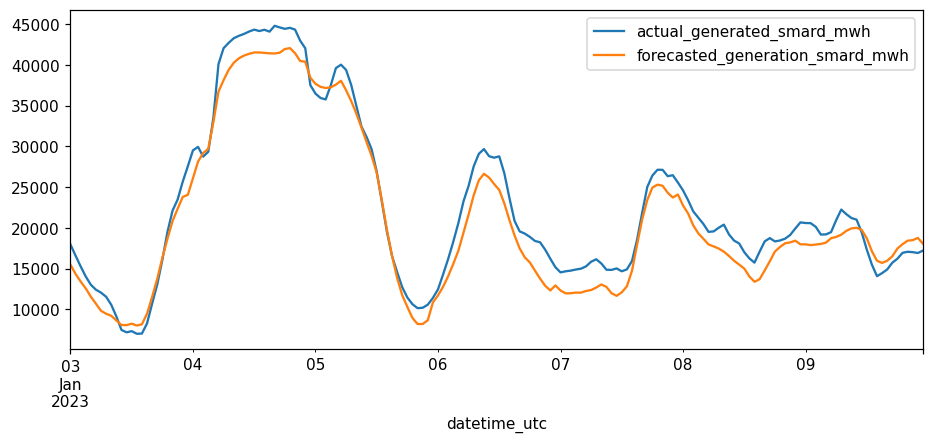

In [395]:
# SMARD actual vs SMARD forecasted
df_smard_preds_vs_actuals.loc['2023-01-03': '2023-01-09'].plot(
    kind='line', y=['actual_generated_smard_mwh', 'forecasted_generation_smard_mwh'],
    figsize=(10,4)
);

In [81]:
# filter on just one day
# df.loc['2023-01-01']

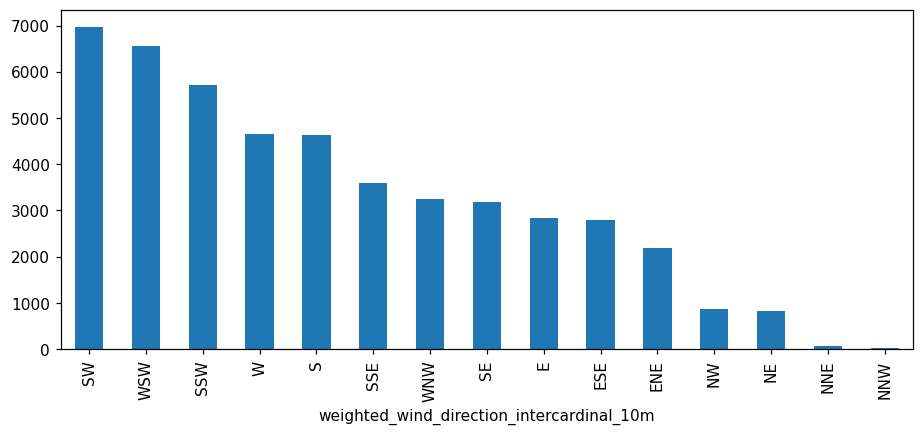

In [396]:
df['weighted_wind_direction_intercardinal_10m'].value_counts().plot(kind='bar', figsize=(10,4));

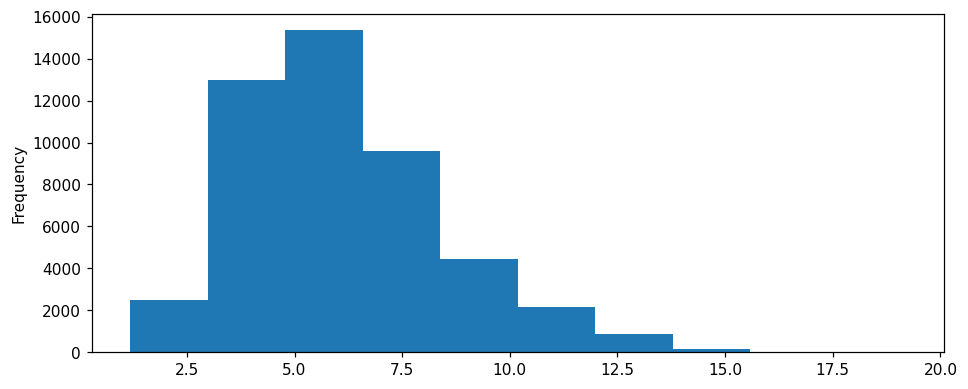

In [397]:
df['weighted_mean_wind_speed_100m'].plot(kind='hist', figsize=(10,4));

In [99]:
df['meteorological_season'].value_counts()

meteorological_season
spring    13248
winter    12240
summer    11760
autumn    10920
Name: count, dtype: int64

#### Maybe plot a windrose of the wind speed AND direction in one plot?

-----

### Plot a seasonal decomposition plot
- Use statsmodels' `seasonal_decompose`
    - https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

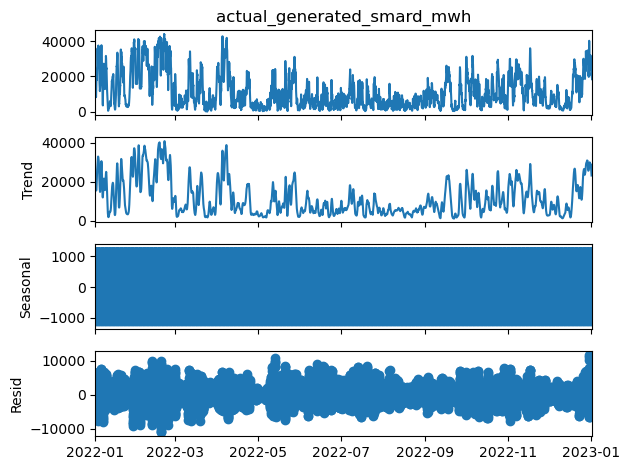

In [96]:
decomposed_result = seasonal_decompose(df.loc['2022-01-01':'2023-01-01', 'actual_generated_smard_mwh'], model='additive')
decomposed_result.plot()
plt.show()

----

### Measuring accuracy of SMARD next-day forecast vs actuals using MAE and RMSE 
- Remember to handle nans --> done
- Use Sklearn's MSE function: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

In [398]:
mse = mean_squared_error(
    df_smard_preds_vs_actuals['actual_generated_smard_mwh'], 
    df_smard_preds_vs_actuals['forecasted_generation_smard_mwh']
)

mse

2209030.6579121514

In [399]:
# Set squared parameter to False to get RMSE
rmse = mean_squared_error(
    df_smard_preds_vs_actuals['actual_generated_smard_mwh'], 
    df_smard_preds_vs_actuals['forecasted_generation_smard_mwh'], 
    squared=False
)

rmse

1486.2808139487474

----

# ~ydata-profiling~
- Main page: https://docs.profiling.ydata.ai/4.5/
- For time series data: https://docs.profiling.ydata.ai/4.5/features/time_series_datasets/
- Doesn't work! There's a bug. I get this issue that others have reported already:
    - https://github.com/ydataai/ydata-profiling/issues/1433

In [66]:
# profile = ProfileReport(df, tsmode=True, title='Time series EDA')
# profile.to_file(data_push_path / 'time_series_report.html')

-------

## More exploratory analysis 
- Seaborn warnings: https://github.com/mwaskom/seaborn/issues/3462

#### Boxplots of power generated by season
- Most hourly power is generated in the winter and the least in the summer
- Change the color palette and/or hue so they are all the same (since different hues imply some sort of order)

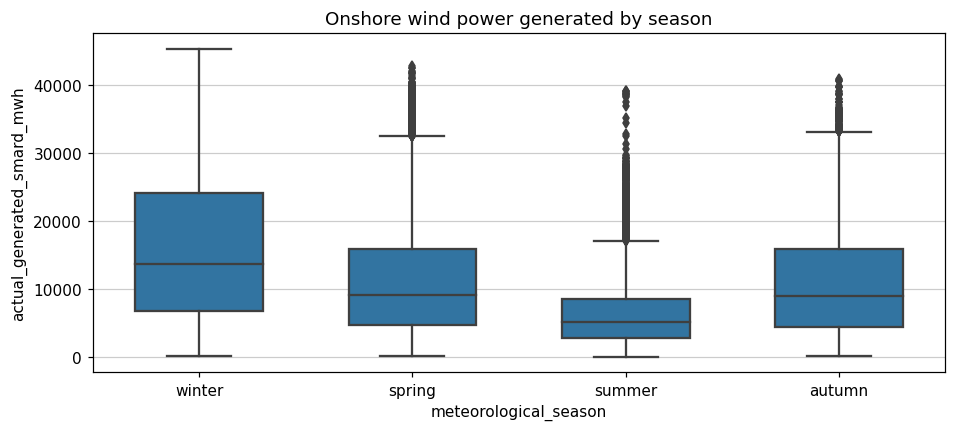

In [568]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Onshore wind power generated by season')
sns.boxplot(data=df, x='meteorological_season', y='actual_generated_smard_mwh', width=0.6, color='tab:blue')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='-', axis='y', alpha=0.4)

In [413]:
df.columns

Index(['hour', 'day_of_week', 'day_of_month', 'day_of_year', 'week_of_year',
       'month_number', 'year', 'meteorological_season', 'public_holiday',
       'turbines_in_operation',
       'total_nominal_capacity_operational_turbines_mw',
       'total_nominal_capacity_smard_mw', 'day_ahead_price_eur_mwh',
       'total_net_load_smard_mwh', 'residual_load_smard_mwh',
       'temp_2m_celsius', 'mean_sea_level_pressure_mb', 'wind_gusts_10m',
       'mean_wind_speed_10m', 'mean_wind_speed_100m',
       'wind_direction_angle_10m', 'wind_direction_angle_100m',
       'wind_direction_intercardinal_10m', 'wind_direction_intercardinal_100m',
       'weighted_temp_2m_celsius', 'weighted_mean_sea_level_pressure_mb',
       'weighted_wind_gusts_10m', 'weighted_mean_wind_speed_10m',
       'weighted_mean_wind_speed_100m',
       'weighted_mean_wind_direction_angle_10m',
       'weighted_mean_wind_direction_angle_100m',
       'weighted_wind_direction_intercardinal_10m',
       'weighted_wind_dire

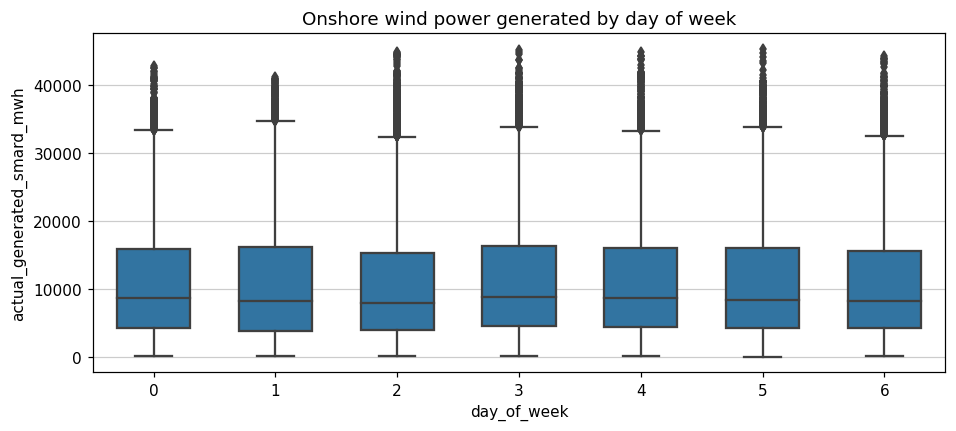

In [569]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Onshore wind power generated by day of week')
sns.boxplot(data=df, x='day_of_week', y='actual_generated_smard_mwh', width=0.6, color='tab:blue')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='-', axis='y', alpha=0.4)

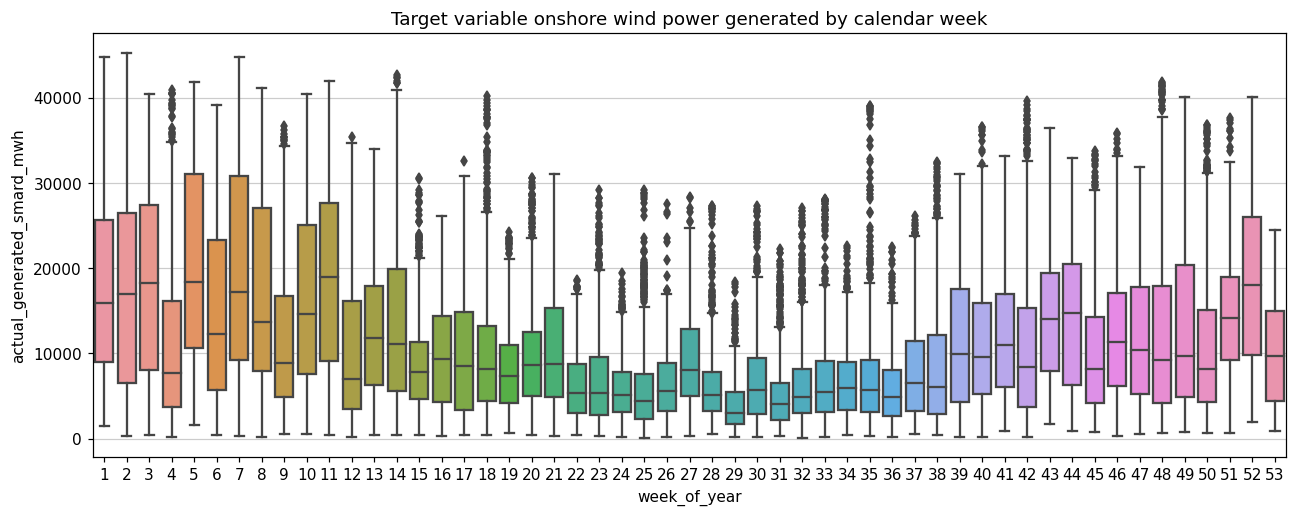

In [550]:
fig, ax = plt.subplots(figsize=(14,5))
ax.set_title('Target variable onshore wind power generated by calendar week')
sns.boxplot(data=df, x='week_of_year', y='actual_generated_smard_mwh')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='-', axis='y', alpha=0.4)

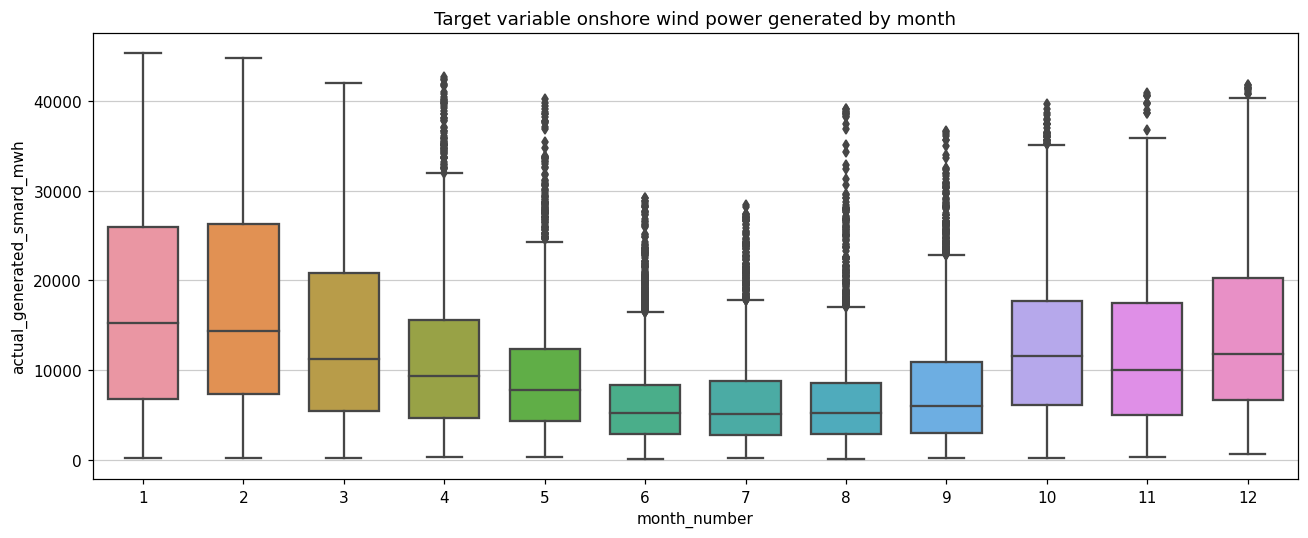

In [549]:
fig, ax = plt.subplots(figsize=(12,5))
ax.set_title('Target variable onshore wind power generated by month')
sns.boxplot(data=df, x='month_number', y='actual_generated_smard_mwh', width=0.7)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='-', axis='y', alpha=0.4)
plt.tight_layout()

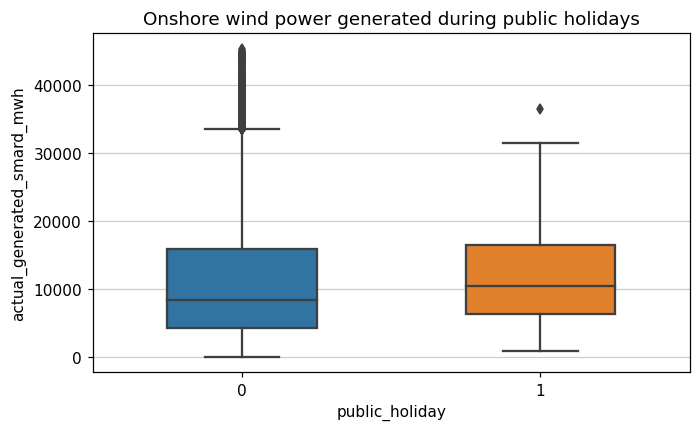

In [493]:
fig, ax = plt.subplots(figsize=(7,4))
ax.set_title('Onshore wind power generated during public holidays')
sns.boxplot(data=df, x='public_holiday', y='actual_generated_smard_mwh', width=0.5)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='-', axis='y', alpha=0.4)

#### Wind direction. Group and get median hourly power generated for each intercardinal direction and sort values

In [477]:
df['wind_direction_intercardinal_100m'].value_counts()

wind_direction_intercardinal_100m
SW     6756
WSW    6461
SSW    5930
S      5032
W      4857
SSE    4027
SE     3252
E      2874
WNW    2820
ESE    2756
ENE    2145
NW      609
NE      585
NNE      41
NNW      23
Name: count, dtype: int64

In [467]:
df.groupby(by='wind_direction_intercardinal_100m')['actual_generated_smard_mwh'].median().sort_values(ascending=False)

wind_direction_intercardinal_100m
NNW    12835.250
NW     12316.250
WSW    12203.500
NNE    11713.750
WNW    11626.000
W      11046.500
SW     10592.250
NE      9507.000
SSW     8170.750
ENE     7988.500
E       6712.000
S       6625.625
SSE     5678.000
ESE     5504.750
SE      4880.250
Name: actual_generated_smard_mwh, dtype: float64

In [471]:
# Get sorted index as list and supply to seaborn boxplot to order the boxplots
directions_sorted = df.groupby(
    by='wind_direction_intercardinal_100m')['actual_generated_smard_mwh'].median().sort_values(ascending=False).index.to_list()

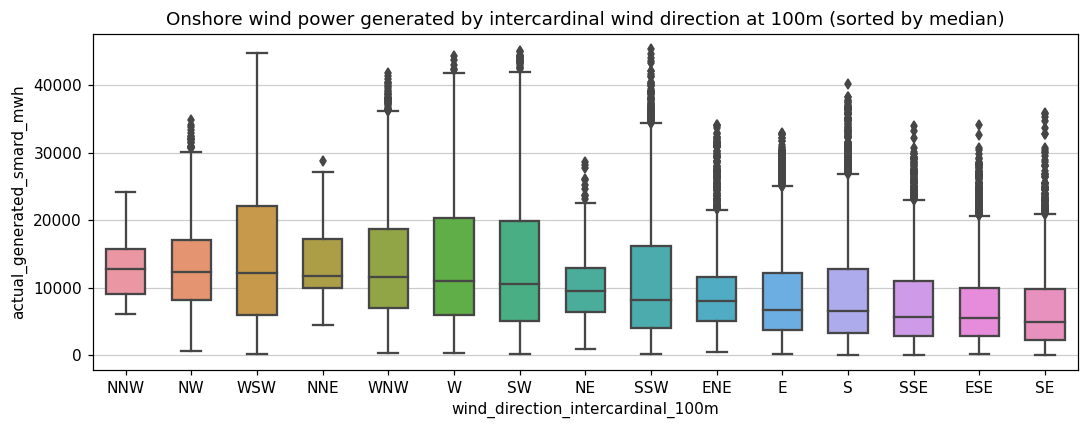

In [494]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Onshore wind power generated by intercardinal wind direction at 100m (sorted by median)')
sns.boxplot(data=df, x='wind_direction_intercardinal_100m', y='actual_generated_smard_mwh', width=0.6, order=directions_sorted)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='-', axis='y', alpha=0.4)
plt.tight_layout()

------

## Distribution of target

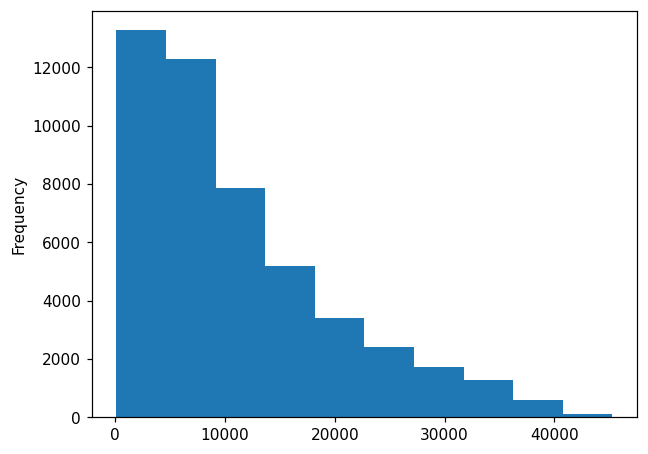

In [495]:
df['actual_generated_smard_mwh'].plot(kind='hist');

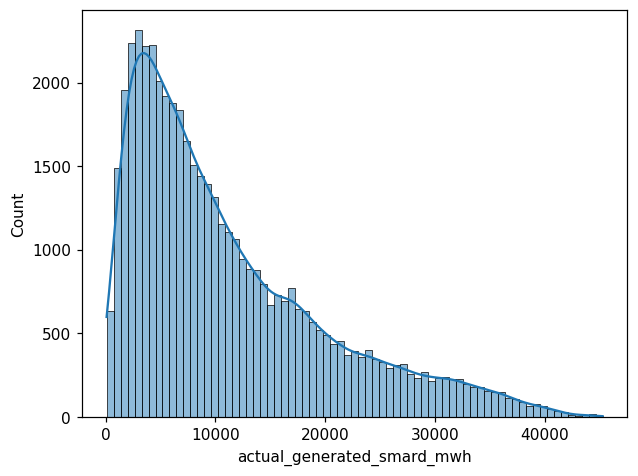

In [483]:
sns.histplot(data=df, x='actual_generated_smard_mwh', kde=True);

### Histograms and KDEs of wind speeds

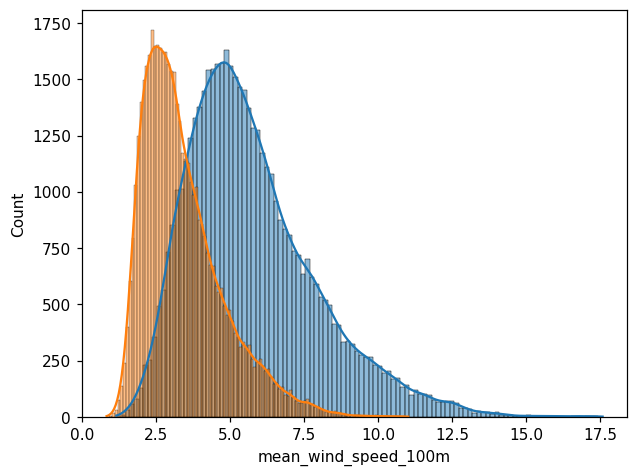

In [502]:
sns.histplot(data=df, x='mean_wind_speed_100m', kde=True)
sns.histplot(data=df, x='mean_wind_speed_10m', kde=True)
plt.show()

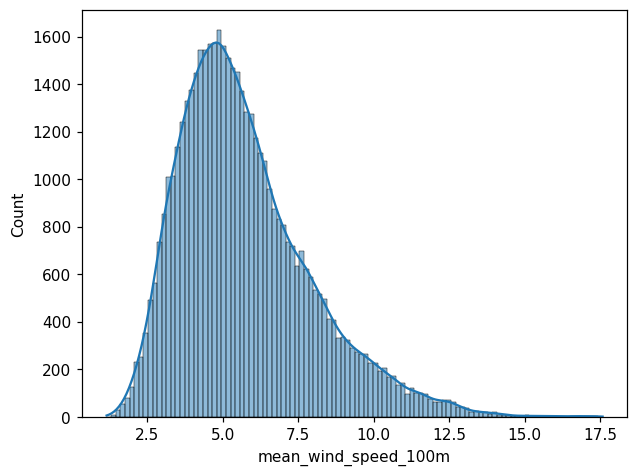

In [484]:
sns.histplot(data=df, x='mean_wind_speed_100m', kde=True);

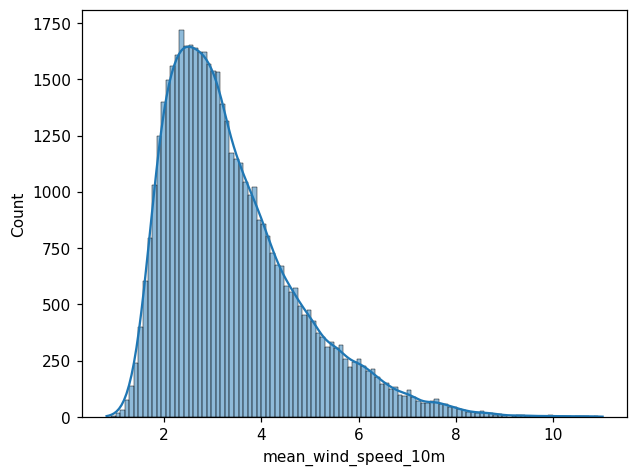

In [485]:
sns.histplot(data=df, x='mean_wind_speed_10m', kde=True);

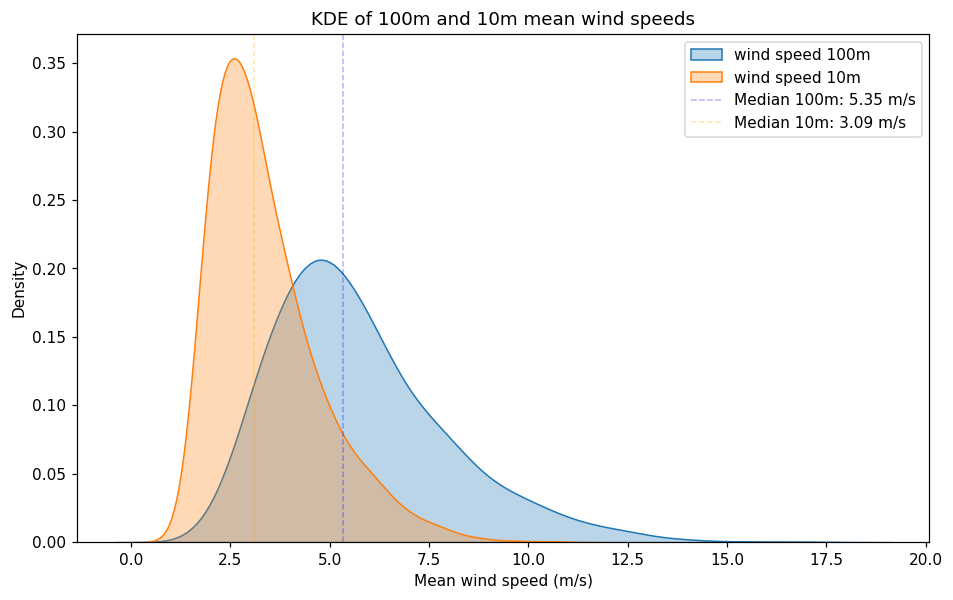

In [527]:
median_100m = df['mean_wind_speed_100m'].median()
median_10m = df['mean_wind_speed_10m'].median()

plt.figure(figsize=(10, 6))
# Plotting KDEs
sns.kdeplot(df['mean_wind_speed_100m'], label='wind speed 100m', shade=True, alpha=0.3, bw_adjust=2)
sns.kdeplot(df['mean_wind_speed_10m'], label='wind speed 10m', shade=True, alpha=0.3, bw_adjust=2)

plt.title('KDE of 100m and 10m mean wind speeds')
plt.xlabel('Mean wind speed (m/s)')
# plot the median line (peaks of KDE are the modes!)
plt.axvline(median_100m, color='blue', linestyle='--', linewidth=1, label=f'Median 100m: {median_100m:.2f} m/s', alpha=0.3)
plt.axvline(median_10m, color='orange', linestyle='--', linewidth=1, label=f'Median 10m: {median_10m:.2f} m/s', alpha=0.3)
# plt.grid(color='gray', linestyle='-', axis='y', alpha=0.4)


plt.legend()

# plt.savefig(data_path.joinpath('visuals').joinpath('test.png'), dpi=300)
plt.show()

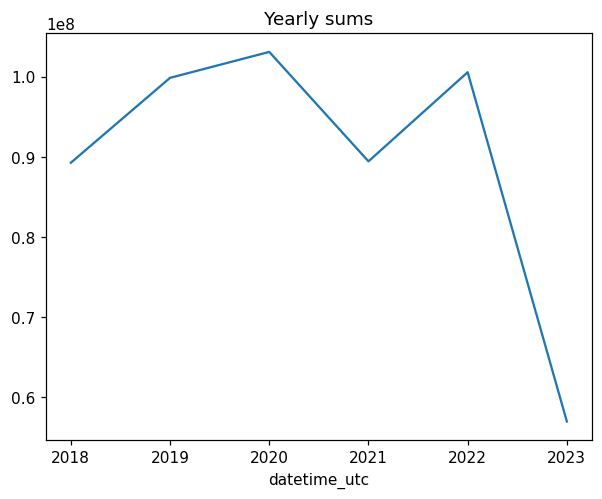

In [544]:
# Resample
yearly_sums = df['actual_generated_smard_mwh'].resample('Y').sum()

sns.lineplot(data=yearly_sums, x=yearly_sums.index.year, y=yearly_sums.values)
plt.title('Yearly sums')
plt.show()

#### Resampling and grouping give same result

In [541]:
df['actual_generated_smard_mwh'].resample('Y').sum()

datetime_utc
2018-12-31 00:00:00+00:00    8.926244e+07
2019-12-31 00:00:00+00:00    9.986459e+07
2020-12-31 00:00:00+00:00    1.031019e+08
2021-12-31 00:00:00+00:00    8.943353e+07
2022-12-31 00:00:00+00:00    1.005666e+08
2023-12-31 00:00:00+00:00    5.693598e+07
Freq: A-DEC, Name: actual_generated_smard_mwh, dtype: float64

In [542]:
df.groupby(by='year')['actual_generated_smard_mwh'].sum()

year
2018    8.926244e+07
2019    9.986459e+07
2020    1.031019e+08
2021    8.943353e+07
2022    1.005666e+08
2023    5.693598e+07
Name: actual_generated_smard_mwh, dtype: float64